# Homework 4

Due date: May 26, 2024

### Submission instructions: 
- __Autograder will not be used for scoring, but you still need to submit the python file converted from this notebook (.py) and the notebook file (.ipynb) to the code submission window.__ 
To convert a Jupyter Notebook (`.ipynb`) to a regular Python script (`.py`):
  - In Jupyter Notebook: File > Download as > Python (.py)
  - In JupyterLab: File > Save and Export Notebook As... > Executable Script
  - In VS Code Jupyter Notebook App: In the toolbar, there is an Export menu. Click on it, and select Python script.
- Submit `hw4.ipynb` and `hw4.py` on Gradescope under the window "Homework 4 - code". Do **NOT** change the file name.
- Convert this notebook into a pdf file and submit it on Gradescope under the window "Homework 4 - PDF". Make sure all your code and text outputs in the problems are visible. 


### General instructions: 

In this homework, we will use pandas to build a cohort of ICU stays and visualize the results from the MIMIC-IV dataset, which you did for Homework 3 in BIOSTAT 203B. 

For processing the Parquet files, one other option is [`polars`](https://pola.rs/). The package is designed for rapid analysis of data frames, possibly larger than memory, with pandas-like syntax, Apache Arrow-based data representation and the Rust language as its backend. Syntax is similar to what you have used for `pyarrow`. You are allowed to use any method you like for analyzing data, but use of `pyarrow`, `duckdb`, or `polars` is certainly recommended for larger files to save your memory and time. (_Hint_: If you want to try `polars`, look into `scan_parquet()` and `LazyFrame`. The package `polars` supports lazy evaluation similar to what you have seen in the R `arrow` package.)

For visualization, you may use packages `matplotlib`, `seaborn`, and/or `plotly`. The use of `plotnine` is not allowed.

Please run the code below to show your system information:

In [1]:
import json
import platform

import psutil


def get_system_info():
    try:
        info = {}
        info["platform"] = platform.system()
        info["platform-release"] = platform.release()
        info["platform-version"] = platform.version()
        info["architecture"] = platform.machine()
        info["processor"] = platform.processor()
        info["ram"] = str(round(psutil.virtual_memory().total / (1024.0**3))) + " GB"
        for k, v in info.items():
            print(f"{k}:\t{v}")
    except Exception as e:
        logging.exception(e)

In [2]:
get_system_info()

platform:	Linux
platform-release:	6.5.0-28-generic
platform-version:	#29~22.04.1-Ubuntu SMP PREEMPT_DYNAMIC Thu Apr  4 14:39:20 UTC 2
architecture:	x86_64
processor:	x86_64
ram:	63 GB


In [3]:

import os
import re
import duckdb
import numpy as np
import pandas as pd
import polars as pl
import seaborn as sns
import matplotlib as mpl
from matplotlib.lines import Line2D
from matplotlib import pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots



## Problem 1. Visualizing patient trajectory

Visualizing a patient’s encounters in a health care system is a common task in clinical data analysis. In this question, we will visualize a patient’s ADT (admission-discharge-transfer) history and ICU vitals in the MIMIC-IV data.

### (A). ADT history
A patient’s ADT history records the time of admission, discharge, and transfer in the hospital. This figure shows the ADT history of the patient with subject_id `10001217` in the MIMIC-IV data. The x-axis is the calendar time, and the y-axis is the type of event (ADT, lab, procedure). The color of the line segment represents the care unit. The size of the line segment represents whether the care unit is an ICU/CCU. The crosses represent lab events, and the shape of the dots represents the type of procedure. The title of the figure shows the patient’s demographic information and the subtitle shows top 3 diagnoses. Try to create a figure similar to the below:

<figure>
  <img src="https://raw.githubusercontent.com/ucla-biostat-203b/2024winter/main/hw/hw3/10001217_adt.png" style="width:600px">
</figure>


Your figure does not need to be the same, but all the information in this figure should be reasonably arranged in your figure. Hint: consider using `dodge` keyword arguments of seaborn to do something similar to `jitter` of `ggplot2`. 



Hint: We need to pull information from data files `patients.csv.gz`, `admissions.csv.gz`, `transfers.csv.gz`, `labevents.csv.gz`, `procedures_icd.csv.gz`, `diagnoses_icd.csv.gz`, `d_icd_procedures.csv.gz`, and `d_icd_diagnoses.csv.gz`. For the big file `labevents.csv.gz`, use the Parquet file you generated in Homework 3. More information is available in later problems.

For reproducibility, make the Parquet file available at the current working directory, for example, by a symbolic link. Make your code reproducible using relative path.

Do a similar visualization for the patient `10013310`.

### ANSWER 1A

#### Function Documentation

- `csvgz_to_parquet`: Converts all `csv.gz` files in a list of directories to `parquet` using the DuckDB and the os libraries. The os library is used to list all files in the directory and filters for `csv.gz` files. DuckDB is used to ingest as a table where all columns are assigned dtype `string`. The tables are then written as `parquet`.

- `parquet_to_lazydict`: Creates a dictionary of `pl.LazyFrames` using the Polars and os libraries. The os library is used to list all files in the directory and filters for `parquet` files. Polars is used to ingest as a `pl.LazyFrame` by scanning all parquets in a directory and appending them to a dictionary where each key is the filename.

- `lazy_to_df`: Converts `pl.LazyFrames` into a dictionary to `pd.DataFrames` that start with a prefix. The `pd.DataFrame` is a Pandas DataFrame not a Polars DataFrame (`pd.DataFrame`).

- `sid_admissions`: Processes the Admissions LazyFrame by filtering rows by subject ID, selecting columns, and assigning column dtypes. The processed LazyFrame is then added to the dictionary with a new key.

- `sid_patient`: Processes the Patient LazyFrame by filtering rows by subject ID, selecting columns, and assigning column dtypes. The processed LazyFrame is then added to the dictionary with a new key.

- `sid_diagnosis`: Processes the Diagnosis and Diagnosis Key LazyFrames by filtering rows by subject ID, joining with the key set, and assigning column dtypes. The processed LazyFrame is then added to the dictionary with a new key.

- `sid_labevents`: Processes the Lab Events LazyFrame by filtering rows by subject ID and item IDs, selecting columns, and assigning column dtypes. The processed LazyFrame is then added to the dictionary with a new key.

- `sid_procedures`: Processes the Procedures and Procedures Key LazyFrames by filtering by subject ID, joining with the key set, and assigning column dtypes. The processed LazyFrame is then added to the dictionary with a new key.

- `sid_transfer`: Processes the Transfers LazyFrame by filtering rows by subject ID, excluding discharge events, selecting columns, and assigning column dtypes. The processed LazyFrame is then added to the dictionary with a new key.

- `sid_chartevents`: This function processes the Chartevents and Chartevents key LazyFrames by filtering rows based on a subject ID and item IDs, joining with the key set, and assigning column dtypes. The processed LazyFrame is then added to the dictionary with a new key.

- `create_lazy_and_plot_df`: This function creates a dictionary of LazyFrames and a dictionary of dataframes. The lazyframe dictionary contains all datasets including plot datasets. The dataframe dictionary containes collected lazyframes needed to make plots for an subject ID. First, the lazyframe dictionary is created from all Parquet files in a directory. Then the lazyframes that will be used to make plots are prepared using the sid_{dataset}() functions which filter, select, assign types, and/or join keys. There is also an error checker for robustness that returns all of the all of the names that are required but not included as a key in lazydict.

In [103]:
def csvgz_to_parquet(dir_list: list[str]) -> None:
    """
    Convert all csv.gz files in a directory list to parquet files.
    All columns are dtype string.
    ---
    Args:
        dir_list: A list of the realtive or absolute directory paths.
    Return:
        None
    """
    # loop through user provided list
    for path in dir_list:
        # Loop through all files in directory
        for filename in os.listdir(path):
            # Ignore dot-files
            if filename.startswith("."):
                continue
            # if filename ends with ".csv.gz"
            if filename.endswith(".csv.gz"):
                # path to .csv.gz
                file_path = os.path.join(path, filename)
                # parquet name
                pq_name = filename.split(".")[0] + ".parquet"
                # parquet save path
                pq_path = os.path.join(path, pq_name)
                print(file_path, " to ", pq_path)  # Verbose step
                with duckdb.connect(database=":memory:") as con:
                    # Read in the compressed file from .csv.gz file path
                    # Set All columns to type string with ALL_VARCHAR
                    # Set ___ to null
                    # Write table as Parquet
                    con.execute(
                        f"""
                            COPY (
                                SELECT * FROM read_csv_auto(
                                    '{file_path}', 
                                    ALL_VARCHAR=True,
                                    nullstr=['___', '']
                                )
                            ) 
                            TO '{pq_path}' (FORMAT PARQUET);
                        """
                    )


def parquet_to_lazydict(dir_path: str) -> dict[str, pl.LazyFrame]:
    """
    Read in all parquet files in a directory with Polars as LazyFrames.
    ---
    Args:
        dir_path: A string of the realtive or absolute directory path.
    Return:
        lazy_dict: A dictionary of LazyFrames.
    """
    # Initialize lazyframe dictionary
    lazy_dict = dict()
    # Loop through every file in directory
    for file in os.listdir(dir_path):
        # Select files that end with parquet
        if file.endswith(".parquet"):
            # Path to each parquet
            name = file.split(".")[0]
            file_path = os.path.join(dir_path, file)
            # append each entry to lazy_dict
            # key is file name and value is lazyframe
            lazy_dict[name] = pl.scan_parquet(file_path)
    return lazy_dict


def lazy_to_df(lazy_dict: dict[str, pl.LazyFrame], prefix: str) -> pl.DataFrame:
    """
    Convert pl.LazyFrames to pl.DataFrames in a dictionary where the key starts
    with the prefix.
    ---
    Args:
        lazy_dict: Dictionary of Polars LazyFrames
        prefix: String and prefix of key in dictionary
    Return:
        df_dict: A dictionary of Polars DataFrames
    """
    df_dict = dict()  # init dict
    # Loop through all values in lazyframe dictionary
    for key, value in lazy_dict.items():
        # Filter LazyFrames by keys that start with the prefix
        if key.startswith(prefix):
            # Verbose for Debugging
            print(f'Collecting {key} LazyFrame ...')
            # Convert pl.LazyFrame to pl.DataFrame and Save to dictionary
            df_dict[key] = value.collect().to_pandas()
    return df_dict


def sid_admissions(lazy_dict: dict[str, pl.LazyFrame], sid: str) -> dict:
    """
    Filter rows, select columns, and assign dtypes to the Admissions dataset.
    ---
    Args:
        lazy_dict: A dictionary of Polars LazyFrames
        sid: A string of digits corresponding to the Subject ID.
    Return:
        lazy_dict: A dictionary of Polars LazyFrames and a processed plot table.
    """
    lazy_dict["plot_admissions"] = (
        # Admissions Dataset
        lazy_dict["admissions"]
        # filter by sid
        .filter(pl.col("subject_id") == sid)
        # select columns to keep
        .select(
            [
                "subject_id",
                "hadm_id",
                "admittime",
                "dischtime",
                "deathtime",
                "admission_type",
                "admit_provider_id",
                "admission_location",
                "discharge_location",
                "insurance",
                "language",
                "marital_status",
                "race",
                "edregtime",
                "edouttime",
            ]
        )
        # Change column dtype
        .cast(
            {
                "subject_id": pl.Int64,
                "hadm_id": pl.Int64,
                "admission_type": pl.String,
                "admit_provider_id": pl.String,
                "admission_location": pl.String,
                "discharge_location": pl.String,
                "insurance": pl.String,
                "language": pl.String,
                "marital_status": pl.String,
                "race": pl.String,
            }
        )
        # Change column dtype to Date
        .with_columns(
            pl.col("admittime").str.to_datetime("%Y-%m-%d %H:%M:%S"),
            pl.col("dischtime").str.to_datetime("%Y-%m-%d %H:%M:%S"),
            pl.col("deathtime").str.to_datetime(
                "%Y-%m-%d %H:%M:%S", 
                strict=False
            ),
            pl.col("edregtime").str.to_datetime("%Y-%m-%d %H:%M:%S"),
            pl.col("edouttime").str.to_datetime("%Y-%m-%d %H:%M:%S"),
        )
    )
    return lazy_dict


def sid_patient(lazy_dict: dict[str, pl.LazyFrame], sid: str) -> dict:
    """
    Filter rows, select columns, and assign dtypes to the Patient dataset.
    ---
    Args:
        lazy_dict: A dictionary of Polars LazyFrames
        sid: A string of digits corresponding to the Subject ID.
    Return:
        lazy_dict: A dictionary of Polars LazyFrames and a processed plot table.
    """

    lazy_dict["plot_patient"] = (
        # Patient Info Dataset
        lazy_dict["patients"]
        # Filter by sid
        .filter(pl.col("subject_id") == sid)
        # Change column dtype
        .cast(
            {
                "subject_id": pl.Int64,
                "anchor_age": pl.Int64,
                "anchor_year": pl.Int64,
                "dod": pl.Date,
            }
        )
        .join(lazy_dict["admissions"].cast({'subject_id':pl.Int64}), on='subject_id')
    )
    return lazy_dict


def sid_diagnosis(lazy_dict: dict[str, pl.LazyFrame], sid: str) -> dict:
    """
    Filter rows, select columns, join item key, and assign dtypes
    to the Diagnosis dataset.
    ---
    Args:
        lazy_dict: A dictionary of Polars LazyFrames
        sid: A string of digits corresponding to the Subject ID.
    Return:
        lazy_dict: A dictionary of Polars LazyFrames and a processed plot table.
    """
    lazy_dict["plot_diagnosis"] = (
        # diagnosis dataset
        lazy_dict["diagnoses_icd"]
        # Filter by sid
        .filter(pl.col("subject_id") == sid)
        # Change column dtype
        .cast({"subject_id": pl.Int64, "hadm_id": pl.Int64, "seq_num": pl.Int64})
        # Join diagnosis key
        .join(lazy_dict["d_icd_diagnoses"], on="icd_code", how="left")
        # Convert short title from long title
        .with_columns(
            pl.col("long_title").str.extract(r"^[^,]*", 0).alias("short_title")
        )
    )
    return lazy_dict


def sid_labevents(lazy_dict: dict[str, pl.LazyFrame], sid: str) -> dict:
    """
    Filter rows, select columns, and assign dtypes to the Lab Events dataset.
    ---
    Args:
        lazy_dict: A dictionary of Polars LazyFrames
        sid: A string of digits corresponding to the Subject ID.
    Return:
        lazy_dict: A dictionary of Polars LazyFrames and a processed plot table.
    """
    # list of itemids to filter by
    lab_itemid = [
        "50912",
        "50971",
        "50983",
        "50902",
        "50882",
        "51221",
        "51301",
        "50931",
    ]

    lazy_dict["d_labitems"] = (
        lazy_dict["d_labitems"]
        .select(["itemid", "label"])
        .filter(pl.col("itemid").is_in(lab_itemid))
        .cast({"itemid": pl.Int64})
    )

    lazy_dict["plot_lab"] = (
        # Labevents dataset
        lazy_dict["labevents"]
        # select columns to keep
        .select(
            [
                "labevent_id",
                "subject_id",
                "hadm_id",
                "specimen_id",
                "itemid",
                "order_provider_id",
                "charttime",
                "storetime",
                "valuenum",
                "valueuom",
            ]
        )
        # Filter by sid and itemid
        .filter(pl.col("subject_id") == sid, pl.col("itemid").is_in(lab_itemid))
        # Change column dtype
        .cast(
            {
                "labevent_id": pl.Int64,
                "subject_id": pl.Int64,
                "hadm_id": pl.Int64,
                "specimen_id": pl.Int64,
                "itemid": pl.Int64,
                "valuenum": pl.Float64,
            }
        )
        # Convert dtype to datetime
        .with_columns(
            pl.col("charttime").str.to_datetime("%Y-%m-%d %H:%M:%S"),
            pl.col("storetime").str.to_datetime("%Y-%m-%d %H:%M:%S"),
            pl.lit('Lab Events').alias('Data')
        )
        .join(lazy_dict["d_labitems"], on="itemid", how="left")
    )
    return lazy_dict


def sid_procedures(lazy_dict: dict[str, pl.LazyFrame], sid: str) -> dict:
    """
    Filter rows, select columns, join item key, and assign dtypes
    to the Procedures dataset.
    ---
    Args:
        lazy_dict: A dictionary of Polars LazyFrames
        sid: A string of digits corresponding to the Subject ID.
    Return:
        lazy_dict: A dictionary of Polars LazyFrames and a processed plot table.
    """
    # preparing procedure key
    lazy_dict["d_icd_procedures"] = lazy_dict["d_icd_procedures"].select(
        ["icd_code", "long_title"]
    )

    lazy_dict["plot_procedures"] = (
        # procedure dataset
        lazy_dict["procedures_icd"]
        # select columns to keep
        .select(["subject_id", "hadm_id", "seq_num", "chartdate", "icd_code"])
        # Filter by sid
        .filter(pl.col("subject_id") == sid)
        # Change column dtype
        .cast(
            {
                "subject_id": pl.Int64,
                "hadm_id": pl.Int64,
                "seq_num": pl.Int64,
                "icd_code": pl.String,
                "chartdate": pl.Date,
            }
        )
        # Join procedures key
        .join(lazy_dict["d_icd_procedures"], on="icd_code", how="left")
        # convert long title to short title
        .with_columns(
            pl.col("long_title").str.extract(r"^[^,]*", 0).alias("short_title"),
            pl.lit('Procedures').alias('Data'),
        )
    )
    return lazy_dict


def sid_transfer(lazy_dict: dict[str, pl.LazyFrame], sid: str) -> dict:
    """
    Filter rows, select columns, and assign dtypes to the Transfers dataset.
    ---
    Args:
        lazy_dict: A dictionary of Polars LazyFrames
        sid: A string of digits corresponding to the Subject ID.
    Return:
        lazy_dict: A dictionary of Polars LazyFrames and a processed plot table.
    """
    lazy_dict["plot_transfer"] = (
        # transfers dataset
        lazy_dict["transfers"]
        # filter by sid
        .filter(pl.col("subject_id") == sid, pl.col("eventtype") != "discharge")
        # Change column dtype
        .cast(
            {
                "subject_id": pl.Int64,
                "hadm_id": pl.Int64,
                "transfer_id": pl.Int64,
                "eventtype": pl.String,
                "careunit": pl.String,
            }
        ).with_columns(
            # Convert string columns to date
            pl.col("intime").str.to_date("%Y-%m-%d %H:%M:%S"),
            pl.col("outtime").str.to_date("%Y-%m-%d %H:%M:%S"),
            # Add a bivariate critical care column if in ICU or CCU
            (
                pl.when(pl.col("careunit").str.contains("ICU|CCU"))
                .then(pl.lit("Yes"))
                .otherwise(pl.lit("No"))
                .alias("critical_care")
            ),
            # Add a column ADT with values of ADT
            (
                pl.when(pl.col("careunit").is_not_null())
                .then(pl.lit("ADT"))
                .otherwise(pl.lit(""))
                .alias("Data")
            ),
        )
        .sort('intime', descending=True)
    )
    return lazy_dict


def sid_chartevents(lazy_dict: dict[str, pl.LazyFrame], sid: str) -> dict:
    """
    Filter rows, select columns, join item key, and assign dtypes
    to the Chartevents dataset.
    ---
    Args:
        lazy_dict: A dictionary of Polars LazyFrames
        sid: A string of digits corresponding to the Subject ID.
    Return:
        lazy_dict: A dictionary of Polars LazyFrames and a processed plot table.
    """
    # Chartevents item key
    lazy_dict["d_items"] = (
        lazy_dict["d_items"]
        # select columns to keep
        .select(["itemid", "label", "abbreviation", "unitname"])
        .filter(pl.col("itemid").is_in(["220045", "220181", "220179", "223761", "220210"]),)
        # convert dtype of columns
        .cast(
            {
                "itemid": pl.Int64,
                "label": pl.String,
                "abbreviation": pl.String,
                "unitname": pl.String,
            }
        )
    )

    # Patient chartevents
    lazy_dict["plot_chartevents"] = (
        # Chartevents dataset
        lazy_dict["chartevents"]
        # Filter by sid and itemid
        .filter(
            pl.col("subject_id") == sid,
            pl.col("itemid").is_in(["220045", "220181", "220179", "223761", "220210"]),
        )
        # Select columns to keep
        .select(
            [
                "subject_id",
                "hadm_id",
                "stay_id",
                "charttime",
                "storetime",
                "itemid",
                "valuenum",
                "valueuom",
            ]
        )
        # Change column dtype
        .cast(
            {
                "subject_id": pl.Int64,
                "hadm_id": pl.Int64,
                "stay_id": pl.Int64,
                "itemid": pl.Int64,
                "valuenum": pl.Float64,
                "valueuom": pl.String,
            }
        )
        # Convert columns to datetime
        .with_columns(
            pl.col("charttime").str.to_datetime("%Y-%m-%d %H:%M:%S"),
            pl.col("storetime").str.to_datetime("%Y-%m-%d %H:%M:%S"),
        )
        # join item key
        .join(lazy_dict["d_items"], on="itemid", how="left")
    )
    return lazy_dict


def create_lazy_and_plot_df(sid: int, dir_path: str) -> tuple:
    """
    Create a dictionary with of LazyFrames of all parquet files in a directory.
    Format, filter, and prepare data for use in plots.
    Convert plot lazyframes to dataframes.
    ---
    Args:
        sid: An integer representing a subject ID.
    Returns:
        lazy_dict: A dictionary of LazyFrames
        df_dict: A dictionary of DataFrames
    """
    # Create a dictionary with of LazyFrames of all parquet files in a directory
    lazy_dict = parquet_to_lazydict(dir_path)
    # Convert subject ID to string because columns in parquet are dtype string
    sid = str(sid)
    # list of names converted to lazyframe from directory.
    lazy_names = [key for key in lazy_dict]
    # name requirements.
    req_names = [
        "patients",
        "admissions",
        "transfers",
        "procedures_icd",
        "d_icd_procedures",
        "diagnoses_icd",
        "d_icd_diagnoses",
        "labevents",
        "d_labitems",
        "chartevents",
        "d_items",
    ]
    # list of all required names not in lazy_names
    missing_names = [n for n in req_names if n not in lazy_names]
    # Error Catch before performing filtering fucntions
    if missing_names:
        raise KeyError(f'Names not found: {", ".join(missing_names)}')
    # Fucntions to prepare datasets for graphing and verbose for debugging
    print('Processing Patient ...')
    sid_patient(lazy_dict, sid)
    print('Processing Admissions ...')
    sid_admissions(lazy_dict, sid)
    print('Processing Transfer ...')
    sid_transfer(lazy_dict, sid)
    print('Processing Procedures ...')
    sid_procedures(lazy_dict, sid)
    print('Processing Diagnosis ...')
    sid_diagnosis(lazy_dict, sid)
    print('Processing Labevents ...')
    sid_labevents(lazy_dict, sid)
    print('Processing Chartevents ...')
    sid_chartevents(lazy_dict, sid)
    # convert plot lazyframe to dataframe
    df_dict = lazy_to_df(lazy_dict, "plot")
    # return both lazyframe and plot dataframes
    return lazy_dict, df_dict

#### `.csv.gz` to `parquet` Documentation

- All `.csv.gz` files that were converted to `parquet` using `csvgz_to_parquet`
- DuckDB was faster than Polars. DuckDB took 4 minutes to convert `.csv.gz` files that were converted to `parquet` and Polars took 6 minutes to convert the same `.csv.gz` files that were converted to `parquet`.

In [5]:
%%time
csvgz_paths = ["./mimic/hosp", "./mimic/icu"]
csvgz_to_parquet(csvgz_paths)

./mimic/hosp/poe.csv.gz  to  ./mimic/hosp/poe.parquet
./mimic/hosp/d_hcpcs.csv.gz  to  ./mimic/hosp/d_hcpcs.parquet
./mimic/hosp/poe_detail.csv.gz  to  ./mimic/hosp/poe_detail.parquet
./mimic/hosp/patients.csv.gz  to  ./mimic/hosp/patients.parquet
./mimic/hosp/diagnoses_icd.csv.gz  to  ./mimic/hosp/diagnoses_icd.parquet
./mimic/hosp/emar_detail.csv.gz  to  ./mimic/hosp/emar_detail.parquet
./mimic/hosp/provider.csv.gz  to  ./mimic/hosp/provider.parquet
./mimic/hosp/prescriptions.csv.gz  to  ./mimic/hosp/prescriptions.parquet
./mimic/hosp/drgcodes.csv.gz  to  ./mimic/hosp/drgcodes.parquet
./mimic/hosp/d_icd_diagnoses.csv.gz  to  ./mimic/hosp/d_icd_diagnoses.parquet
./mimic/hosp/d_labitems.csv.gz  to  ./mimic/hosp/d_labitems.parquet
./mimic/hosp/transfers.csv.gz  to  ./mimic/hosp/transfers.parquet
./mimic/hosp/admissions.csv.gz  to  ./mimic/hosp/admissions.parquet
./mimic/hosp/labevents.csv.gz  to  ./mimic/hosp/labevents.parquet
./mimic/hosp/pharmacy.csv.gz  to  ./mimic/hosp/pharmacy.parq

#### Symbolic Link Documentation
- Created Symbolic links from mimic data directories to the working directory. Only performed for the files that were needed to make the plot. Change the Directories to match your system.

In [97]:
%%bash
# Modify bash code to match directories.
ln -sf /media/wtmartinez/Data/mimic ./
ln -sf ./mimic/hosp/patients.parquet ./patients.parquet
ln -sf ./mimic/hosp/admissions.parquet ./admissions.parquet
ln -sf ./mimic/hosp/transfers.parquet ./transfers.parquet
ln -sf ./mimic/hosp/labevents.parquet ./labevents.parquet
ln -sf ./mimic/hosp/procedures_icd.parquet ./procedures_icd.parquet
ln -sf ./mimic/hosp/diagnoses_icd.parquet ./diagnoses_icd.parquet
ln -sf ./mimic/hosp/d_icd_procedures.parquet ./d_icd_procedures.parquet
ln -sf ./mimic/hosp/d_icd_diagnoses.parquet ./d_icmd_diagnoses.parquet
ln -sf ./mimic/hosp/d_labitems.parquet ./d_labitems.parquet
ln -sf ./mimic/icu/icustays.parquet ./icustays.parquet
ln -sf ./mimic/icu/chartevents.parquet ./chartevents.parquet
ln -sf ./mimic/icu/d_items.parquet ./d_items.parquet
echo Confirm All Links are Correct:
find . -type l -ls | awk '{print $(NF-2), $(NF-1), $NF}'

Confirm All Links are Correct:
./transfers.parquet -> ./mimic/hosp/transfers.parquet
./diagnoses_icd.parquet -> ./mimic/hosp/diagnoses_icd.parquet
./mimic -> /media/wtmartinez/Data/mimic
./d_icd_diagnoses.parquet -> ./mimic/hosp/d_icd_diagnoses.parquet
./icustays.parquet -> ./mimic/icu/icustays.parquet
./admissions.parquet -> ./mimic/hosp/admissions.parquet
./d_icmd_diagnoses.parquet -> ./mimic/hosp/d_icd_diagnoses.parquet
./chartevents.parquet -> ./mimic/icu/chartevents.parquet
./d_items.parquet -> ./mimic/icu/d_items.parquet
./procedures_icd.parquet -> ./mimic/hosp/procedures_icd.parquet
./d_labitems.parquet -> ./mimic/hosp/d_labitems.parquet
./patients.parquet -> ./mimic/hosp/patients.parquet
./labevents.parquet -> ./mimic/hosp/labevents.parquet
./d_icd_procedures.parquet -> ./mimic/hosp/d_icd_procedures.parquet


#### Reading and Preparing Data Documentation
- The `create_lazy_and_plot_df` function was used to make a dictionary of lazyframes of all datasets and a dictionary of dataframes of processed plotting datasets.

In [104]:
%%time
lazy_dict, df_dict = create_lazy_and_plot_df(10013310, "./")

Processing Patient ...
Processing Admissions ...
Processing Transfer ...
Processing Procedures ...
Processing Diagnosis ...
Processing Labevents ...
Processing Chartevents ...
CPU times: user 838 ms, sys: 282 ms, total: 1.12 s
Wall time: 315 ms


#### Plotting Documentation
- 

In [8]:
%%time
def transfer_plot(df_dict: dict):
    fig1 = px.timeline(
        data_frame=df_dict['plot_transfer'],
        x_start="intime",
        x_end="outtime",
        y ="Data",
        color='careunit',
        hover_name='careunit',
        pattern_shape='critical_care',
        hover_data={
            'critical_care': False,
            'intime': True,
            'outtime': True,
            'Data': False,
            'careunit': False
        },
        height=500,
        width=1350,
        pattern_shape_map={
            'Yes': 'x',
            'No': None
        }
    )

    fig1.update_layout(
        legend=dict(
            orientation="h",
            yanchor="bottom",
            y=-0.8,
            xanchor="center",
            x=0.5
        )
    )

    fig1.update_traces(width=0.3)
    return fig1

def lab_plot(df_dict: dict):
    fig2 = px.strip(
        data_frame=df_dict['plot_lab'],
        x="charttime",
        y ="Data",
        custom_data='label',
        hover_name='label',
        hover_data={
            'Data': False
        },
        height=500,
        width=1350,
        stripmode='overlay',
        orientation='h'
    )

    fig2.update_traces(width=1, marker=dict(size=14, line_width=0.5, symbol='x-thin'))
    return fig2

def procedure_plot(df_dict: dict):
    fig3 = px.strip(
        data_frame=df_dict['plot_procedures'],
        x="chartdate",
        y ="Data",
        custom_data='short_title',
        hover_name='short_title',
        hover_data={'Data':False},
        height=500,
        width=1350,
        stripmode='overlay',
        orientation='h'
    )

    fig3.update_traces(
        width=1,
        marker=dict(
            size=14,
            line_width=0.3,
            symbol='diamond-dot',
            color='black'
        )
    )
    return fig3

def sid_events_plot(df_dict: dict):
    figs = dict()
    figs['fig1'] = transfer_plot(df_dict)
    figs['fig2'] = lab_plot(df_dict)
    figs['fig3'] = procedure_plot(df_dict)
    for key, value in figs.items():
        value.show()
    append_plot_png()


sid_events_plot(df_dict)



NameError: name 'append_plot_png' is not defined

#### Sources:

__Plot__
- [Title](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.title.html)
- [Plot Font Size 4](https://stackoverflow.com/questions/3899980/how-to-change-the-font-size-on-a-matplotlib-plot)
- [Lineplot](https://seaborn.pydata.org/generated/seaborn.lineplot.html)
- [Stripplot](https://seaborn.pydata.org/generated/seaborn.stripplot.html)
- [Dodge and Jitter](https://seaborn.pydata.org/generated/seaborn.objects.Dodge.html)
- https://www.w3schools.com/python/matplotlib_grid.asp

__Markers__
- [Modifying Markers 1](https://matplotlib.org/stable/api/markers_api.html)
- [Modifying Markers 2](https://seaborn.pydata.org/tutorial/properties.html)
- [Modifying Markers 3](https://stackoverflow.com/questions/52785101/seaborn-scatterplot-marker-size-for-all-markers)

__Color__
- [Manual Color Map 1](https://seaborn.pydata.org/generated/seaborn.color_palette.html)
- [Manual Color Map 2](https://matplotlib.org/stable/api/_as_gen/matplotlib.colors.Colormap.html#matplotlib.colors.Colormap.resampled)
- [Manual Color Map 3](https://stackoverflow.com/questions/16834861/create-own-colormap-using-matplotlib-and-plot-color-scale)
- [Manual Color Map 4](https://stackoverflow.com/questions/70101115/how-to-specify-the-palette-in-a-seaborn-figure-level-plot)

__Legend__
- [Custom Legend 1](https://matplotlib.org/stable/api/_as_gen/matplotlib.lines.Line2D.html#matplotlib.lines.Line2D)
- [Custom Legend 2](https://matplotlib.org/stable/gallery/lines_bars_and_markers/scatter_with_legend.html)
- [Custom Legend 3](https://stackoverflow.com/questions/4700614/how-to-put-the-legend-outside-the-plot)
- [Regex](https://www.guru99.com/python-regular-expressions-complete-tutorial.html)


/home/wtmartinez/anaconda3/envs/203C/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

/home/wtmartinez/anaconda3/envs/203C/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

/home/wtmartinez/anaconda3/envs/203C/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

/home/wtmartinez/anaconda3/envs/203C/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

/home/wtmartinez/anaconda3/envs/203C/lib/python3.11/site-packages/se

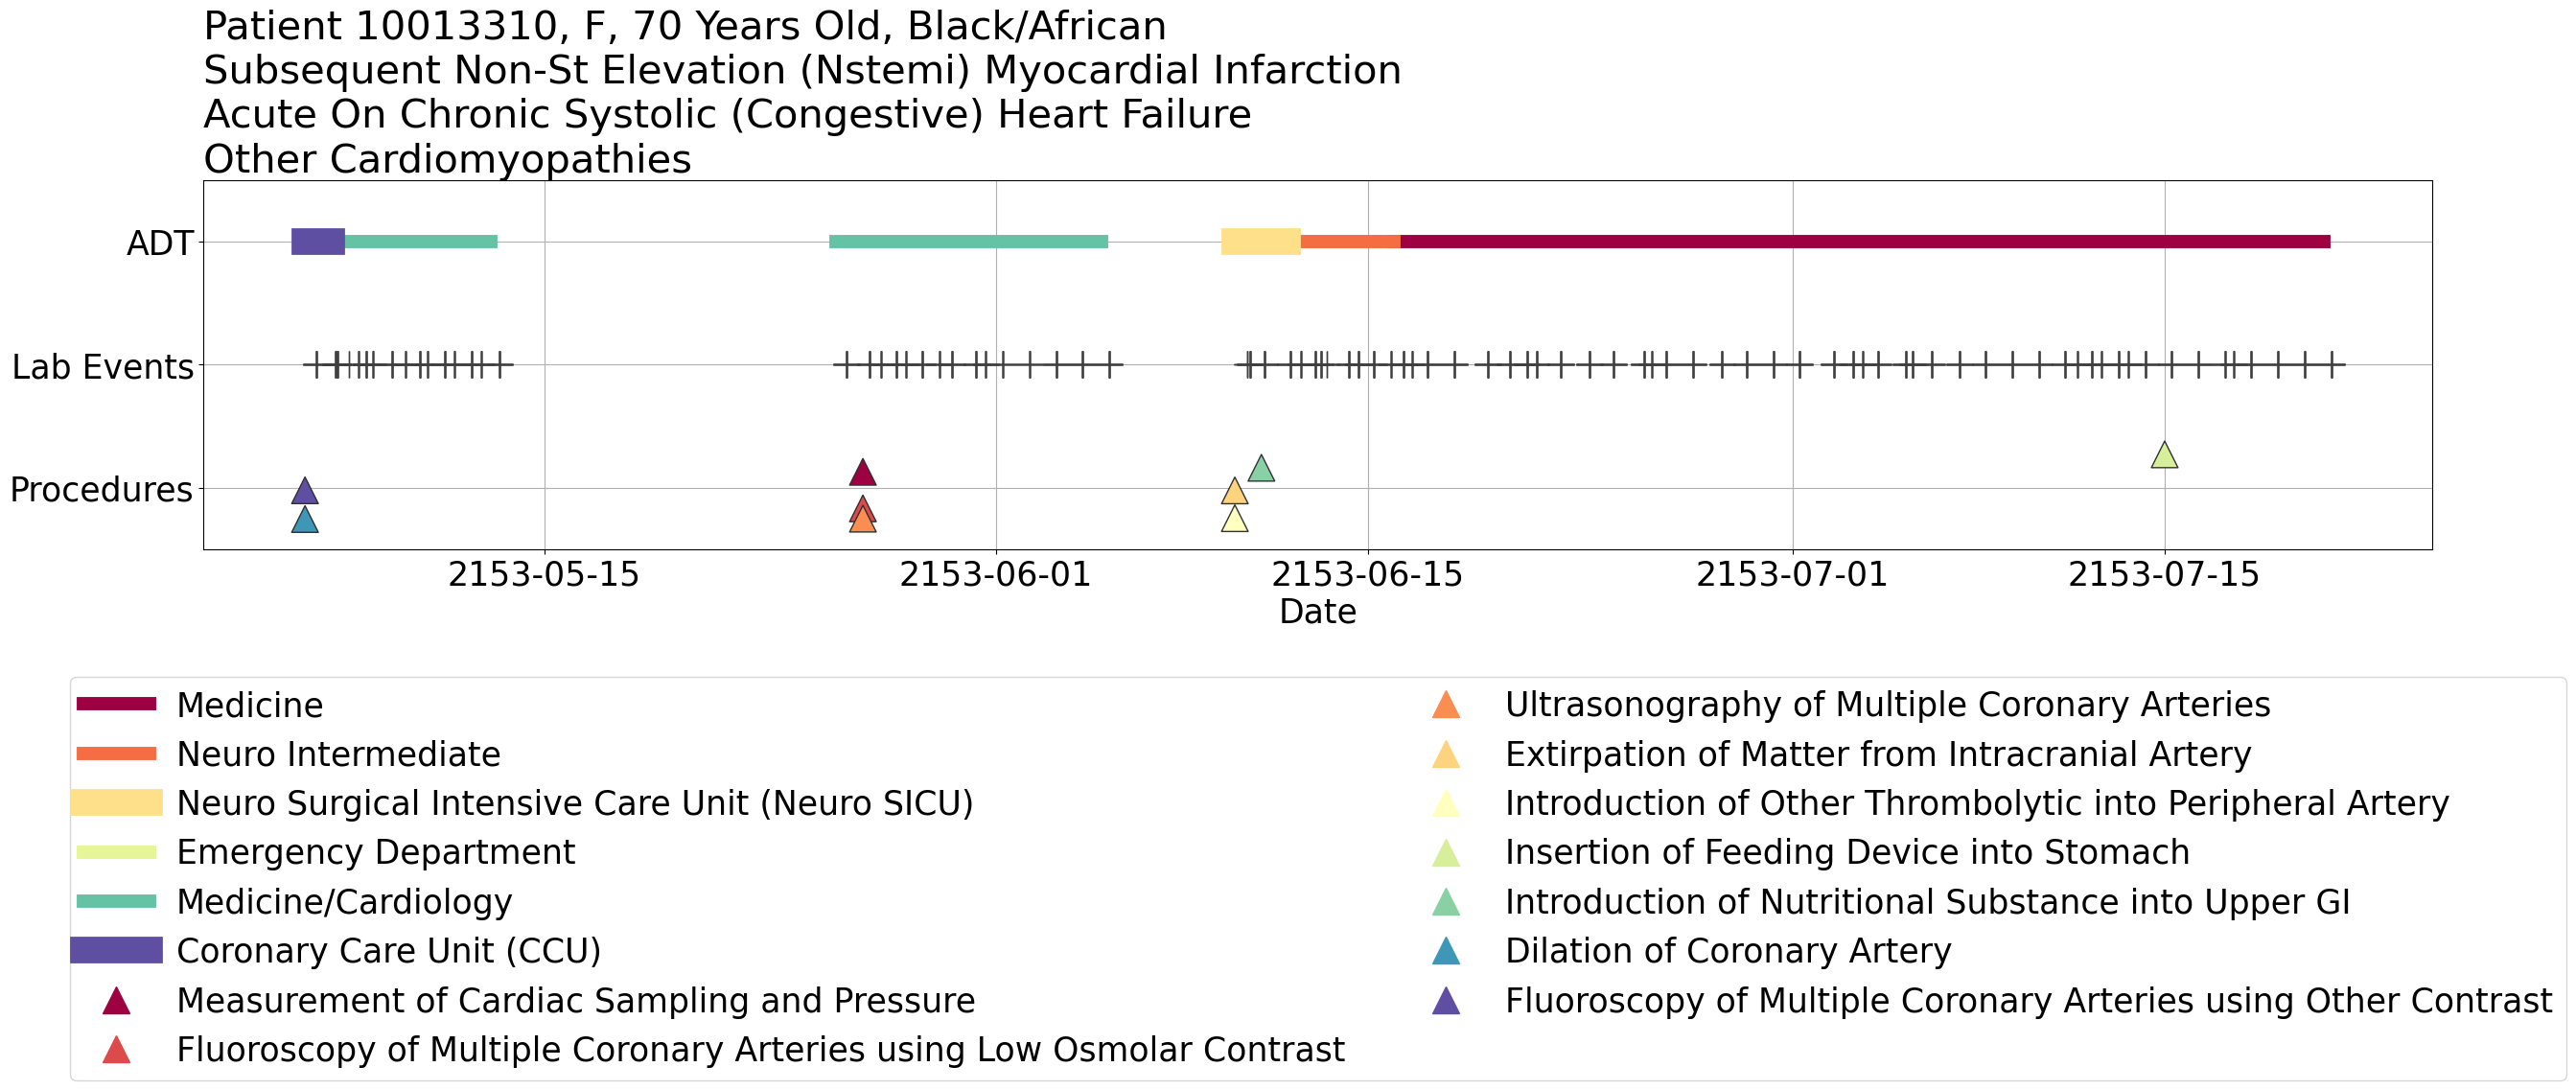

In [95]:
# plt.figure(figsize=(50, 5))
plt.figure(figsize=(30, 5))

unq_unit = df_dict['plot_transfer']['careunit'].unique()
spectral = mpl.colormaps['Spectral'].resampled(len(unq_unit))
unit_palette = {unit: spectral(i) for i, unit in enumerate(unq_unit)}

unq_pro = df_dict['plot_procedures']['short_title'].unique()
spectral = mpl.colormaps['Spectral'].resampled(len(unq_pro))
pro_palette = {unit: spectral(i) for i, unit in enumerate(unq_pro)}

for i, row in df_dict['plot_transfer'].iterrows():
    row_dict = {
        'Date': [row['intime'], row['outtime']],
        'Events': [row['Data'], row['Data']],
        'critical_care': [row['critical_care'], row['critical_care']],
        'careunit': [row['careunit'], row['careunit']],
    }
    row_df = pd.DataFrame(row_dict)
    
    sns.lineplot(
        data=row_df,
        x='Date',
        y='Events',
        hue='careunit',
        size='critical_care',
        markers=True,
        sizes={
            'Yes': 20,
            'No': 10,
        },
        palette=unit_palette,
        legend=False
    )

sns.stripplot(
    data=df_dict['plot_lab'],
    x='charttime',
    y='Data',
    hue='Data',
    dodge=False,
    jitter=False,
    # alpha=1,
    s=20,
    marker='+',
    linewidth=1,
    legend=False,
)

sns.stripplot(
    data=df_dict['plot_procedures'],
    x='chartdate',
    y='Data',
    hue='short_title',
    palette=pro_palette,
    dodge=False,
    jitter= 0.3,
    s=20,
    marker='^',
    linewidth=1,
    legend=False,
)



marker_style = list() 
marker_key = list()

for unit in unq_unit:
    marker_key.append(unit)
    marker_style.append(
        Line2D(
            [0],
            [0], 
            color=unit_palette[unit], 
            linewidth= 20 if re.search("ICU|CCU", unit) else 10,
        )
    )
for procedure in unq_pro:
    marker_key.append(procedure)
    marker_style.append(
        Line2D(
            [0], [0], 
            color=pro_palette[procedure], 
            marker='^', 
            linestyle='None',
            markersize=20 

            
        )
    )


pat = df_dict['plot_patient']
dia = df_dict['plot_diagnosis']
title = (
f"Patient {pat['subject_id'][0]}, {pat['gender'][0]}, {pat['anchor_age'][0]} Years Old, {pat['race'][0].title()}" +
f"\n{dia['short_title'][0].title()}\n{dia['short_title'][1].title()}\n{dia['short_title'][2].title()}"
)
plt.title(title, loc='left')

plt.ylabel(None)
plt.legend(marker_style, marker_key, loc='upper center', bbox_to_anchor=(0.5, -0.3), ncol=2)
plt.rcParams.update({'font.size': 20})
plt.grid()

plt.show()


### (B). ICU stays
ICU stays are a subset of ADT history. This figure shows the vitals of the patient `10001217` during ICU stays. The x-axis is the calendar time, and the y-axis is the value of the vital. The color of the line represents the type of vital. The facet grid shows the abbreviation of the vital and the stay ID. These vitals are: heart rate (220045), systolic non-invasive blood pressure (220179), diastolic non-invasive blood pressure (220180), body temperature in Fahrenheit (223761), and respiratory rate (220210). Try to create a figure similar to below:


<figure>
  <img src="https://raw.githubusercontent.com/ucla-biostat-203b/2024winter/main/hw/hw3/10001217_icu.png" style="width:600px">
</figure>

Repeat a similar visualization for the patient `10013310`.

#### Sources
- https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.subplots.html
- https://seaborn.pydata.org/tutorial/axis_grids.html
- https://matplotlib.org/stable/api/_as_gen/matplotlib.markers.MarkerStyle.html
- https://dev.to/thalesbruno/subplotting-with-matplotlib-and-seaborn-5ei8
- https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.suptitle.html
- https://matplotlib.org/stable/gallery/subplots_axes_and_figures/subplots_demo.html
- https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.filter.html
- https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.isin.html
- https://stackoverflow.com/questions/12096252/use-a-list-of-values-to-select-rows-from-a-pandas-dataframe
- https://www.listendata.com/2019/07/how-to-filter-pandas-dataframe.html
- https://matplotlib.org/stable/gallery/subplots_axes_and_figures/figure_title.html

/home/wtmartinez/anaconda3/envs/203C/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

/home/wtmartinez/anaconda3/envs/203C/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

/home/wtmartinez/anaconda3/envs/203C/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

/home/wtmartinez/anaconda3/envs/203C/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

/home/wtmartinez/anaconda3/envs/203C/lib/python3.11/site-packages/se

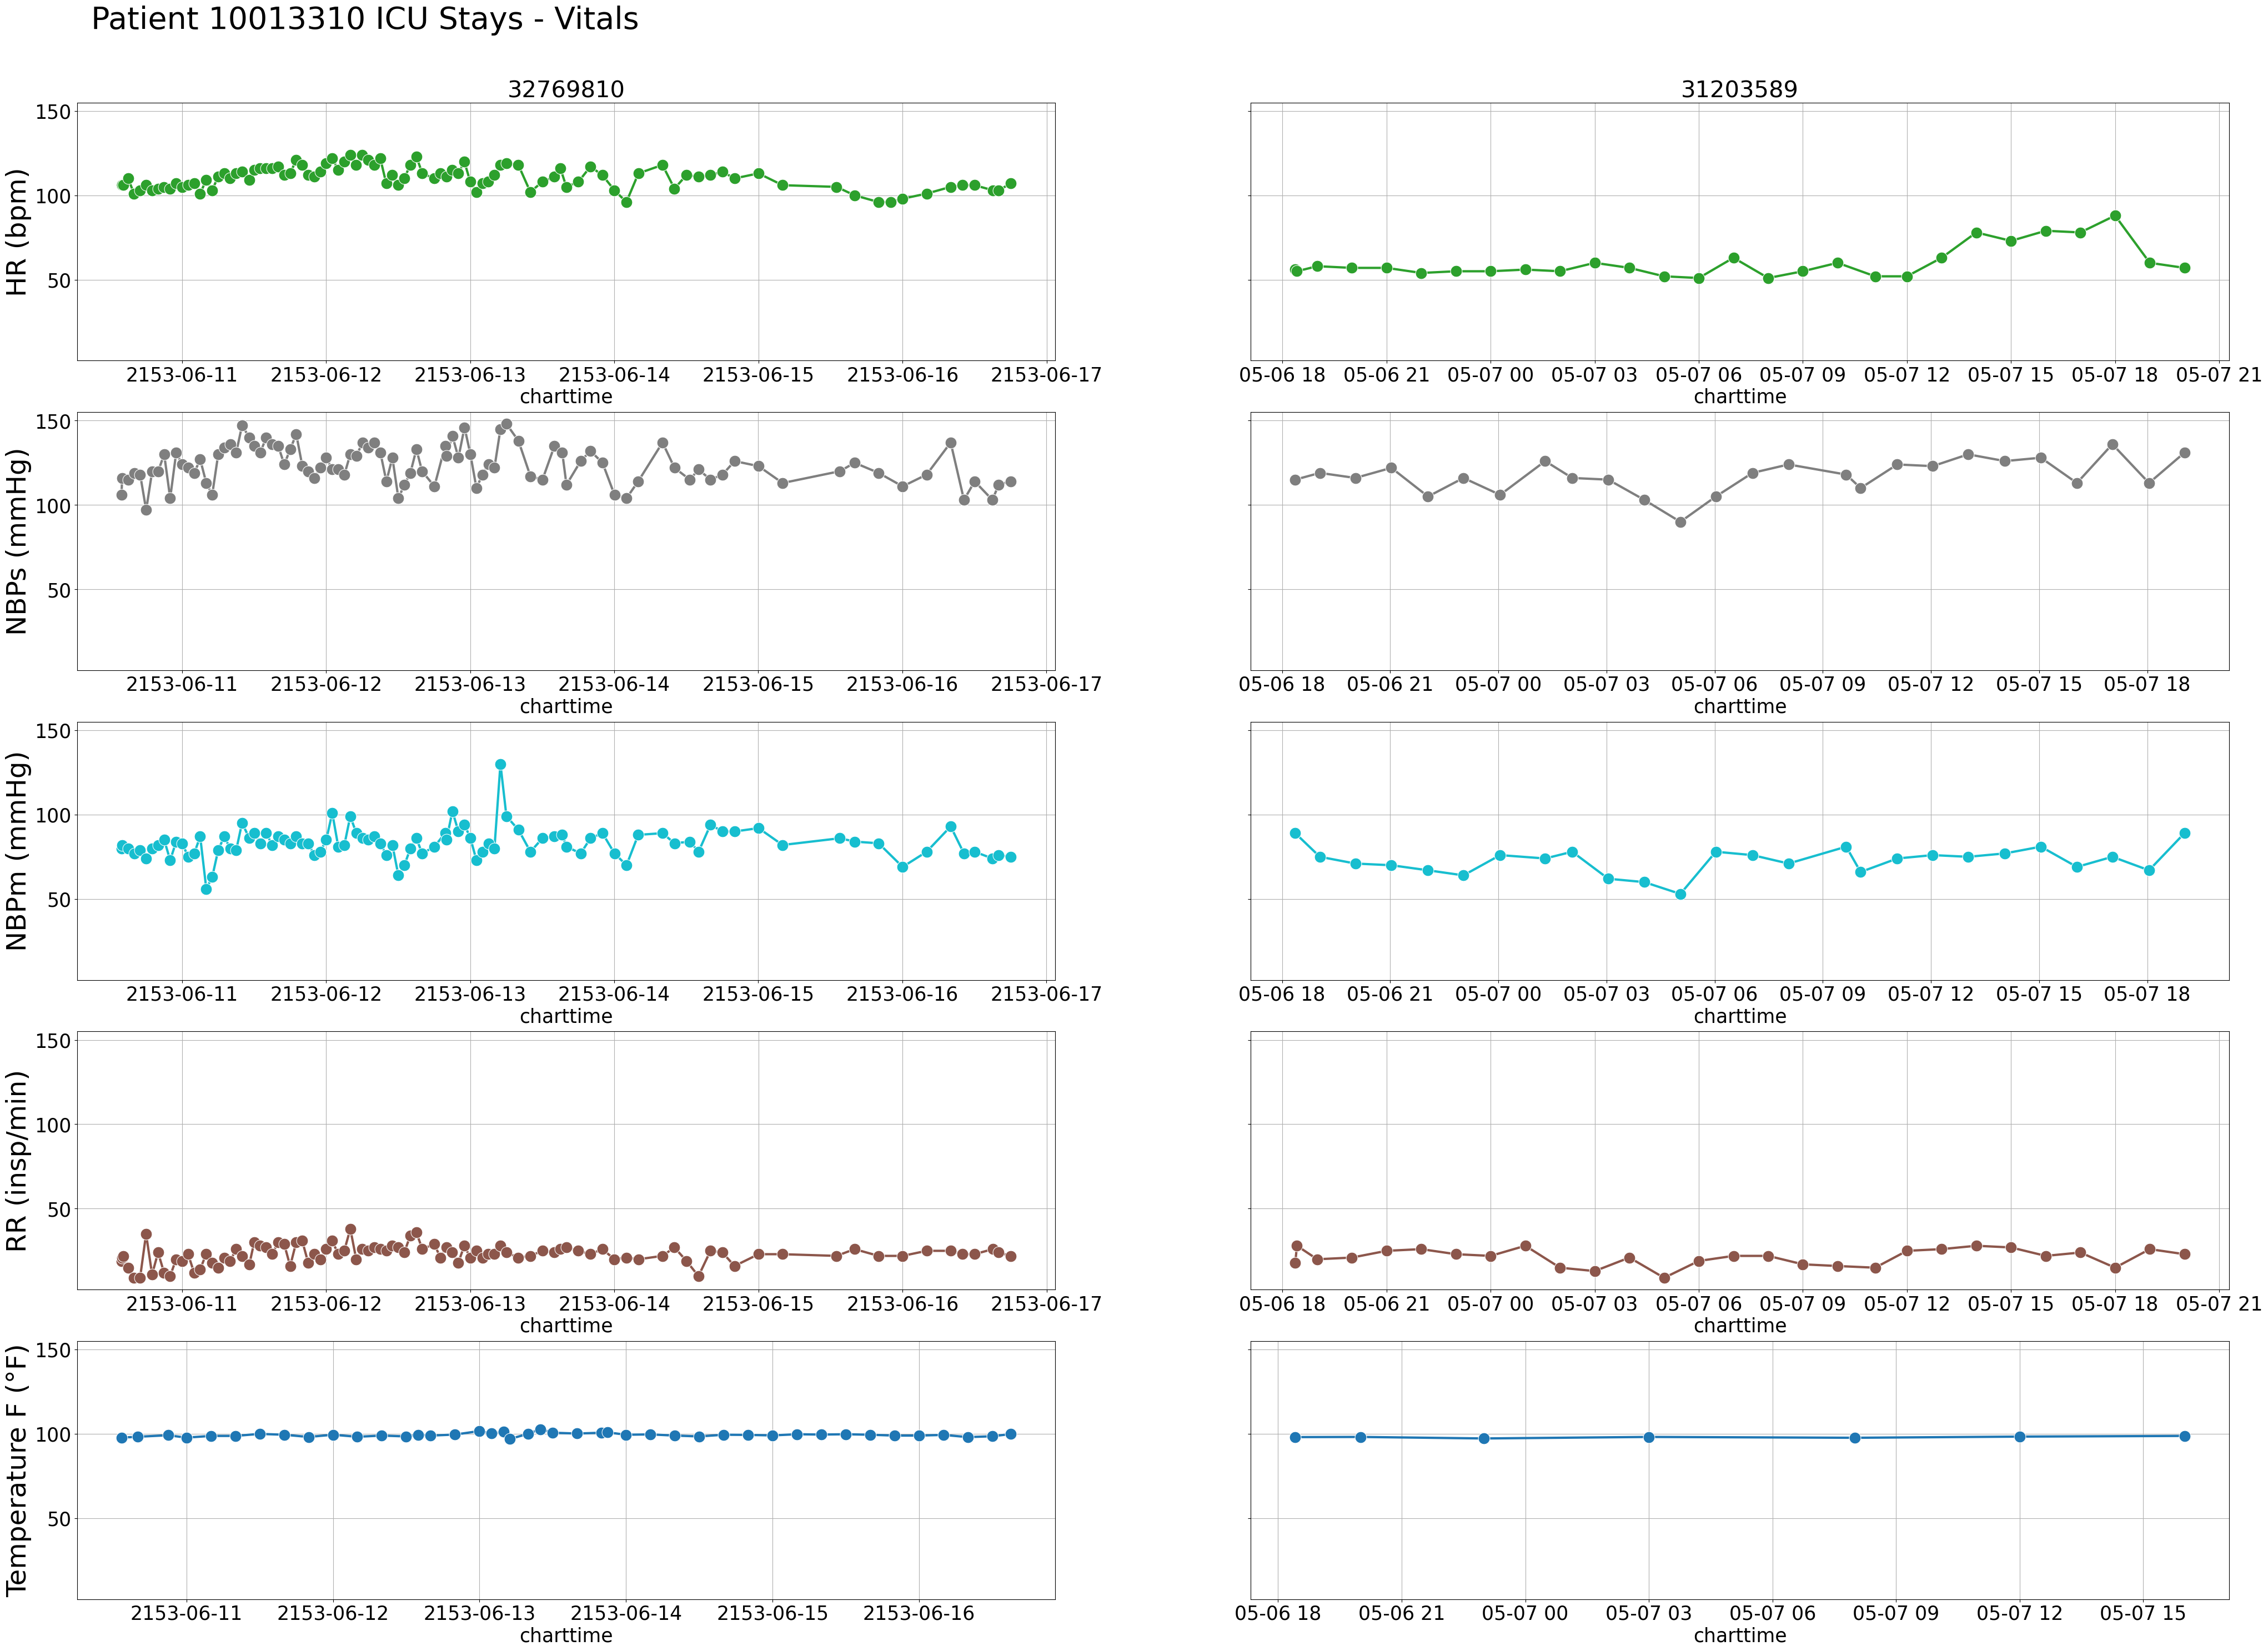

In [94]:
data = df_dict['plot_chartevents']
df_items = lazy_dict['d_items'].collect().to_dict()
patient = df_dict['plot_patient']['subject_id'][0]
names = list(data['abbreviation'].unique())
items = list(data['itemid'].unique())
stays = list(data['stay_id'].unique())

spectral = mpl.colormaps['tab10'].resampled(len(items))
chart_palette = {unit: spectral(i) for i, unit in enumerate(items)}

fig, axes = plt.subplots(
    nrows=len(names), 
    ncols=len(stays),
    sharex=False,
    sharey=True,
    squeeze=True,
    figsize=(50,35))
fig.suptitle(f'Patient {patient} ICU Stays - Vitals', x=0.13, y=.93 ,ha='left', size=40)

for i, stay in enumerate(stays):
    axes[0,i].set_title(f'{stays[i]}')
    for j, item in enumerate(df_items['itemid']):
        abv = df_items['abbreviation'][j]
        units = df_items['unitname'][j]
        axes[j,0].set_ylabel(f'{abv} ({units})',size=35)

for i, item in enumerate(df_items['itemid']):
    for j, stay in enumerate(stays):
        filter = f'itemid == {item} & stay_id == {stay}'
        df = data.query(filter)
        sns.lineplot(
            ax=axes[i, j],
            data=df, 
            x='charttime', 
            y='valuenum',
            hue='itemid',
            palette=chart_palette,
            linewidth=3,
            legend=None,
            marker='o',
            markersize=15,
            errorbar=None)
        axes[i, j].grid(True)


plt.rcParams.update({'font.size': 25})
plt.show()

## Problem 2. ICU stays

`icustays.csv.gz` (https://mimic.mit.edu/docs/iv/modules/icu/icustays/) contains data about Intensive Care Units (ICU) stays. The first 10 lines are:

In [102]:
!zcat < ./mimic/icu/icustays.csv.gz | head

subject_id,hadm_id,stay_id,first_careunit,last_careunit,intime,outtime,los
10000032,29079034,39553978,Medical Intensive Care Unit (MICU),Medical Intensive Care Unit (MICU),2180-07-23 14:00:00,2180-07-23 23:50:47,0.4102662037037037
10000980,26913865,39765666,Medical Intensive Care Unit (MICU),Medical Intensive Care Unit (MICU),2189-06-27 08:42:00,2189-06-27 20:38:27,0.4975347222222222
10001217,24597018,37067082,Surgical Intensive Care Unit (SICU),Surgical Intensive Care Unit (SICU),2157-11-20 19:18:02,2157-11-21 22:08:00,1.1180324074074075
10001217,27703517,34592300,Surgical Intensive Care Unit (SICU),Surgical Intensive Care Unit (SICU),2157-12-19 15:42:24,2157-12-20 14:27:41,0.9481134259259258
10001725,25563031,31205490,Medical/Surgical Intensive Care Unit (MICU/SICU),Medical/Surgical Intensive Care Unit (MICU/SICU),2110-04-11 15:52:22,2110-04-12 23:59:56,1.338587962962963
10001884,26184834,37510196,Medical Intensive Care Unit (MICU),Medical Intensive Care Unit (MICU),2131-01-11 04:20:

### (A). Ingestion

Import `icustays.csv.gz` as a DataFrame `icustays_df`.

In [122]:
prob2 = (
    lazy_dict['icustays']
    .select(['subject_id', 'stay_id'])
    .cast(dict(
        subject_id=pl.Int64,
        stay_id=pl.Int64,))
    .group_by('subject_id', maintain_order=True)
    .len(name='icu_visits')
)

prob2.fetch(10)

shape: (7, 2)
┌────────────┬────────────┐
│ subject_id ┆ icu_visits │
│ ---        ┆ ---        │
│ i64        ┆ u32        │
╞════════════╪════════════╡
│ 10000032   ┆ 1          │
│ 10000980   ┆ 1          │
│ 10001217   ┆ 2          │
│ 10001725   ┆ 1          │
│ 10001884   ┆ 1          │
│ 10002013   ┆ 1          │
│ 10002155   ┆ 3          │
└────────────┴────────────┘

### (B). Summary and visualization

How many unique `subject_id`? Can a `subject_id` have multiple ICU stays? Summarize the number of ICU stays per `subject_id` by graphs.

/home/wtmartinez/anaconda3/envs/203C/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

/home/wtmartinez/anaconda3/envs/203C/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

/home/wtmartinez/anaconda3/envs/203C/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead



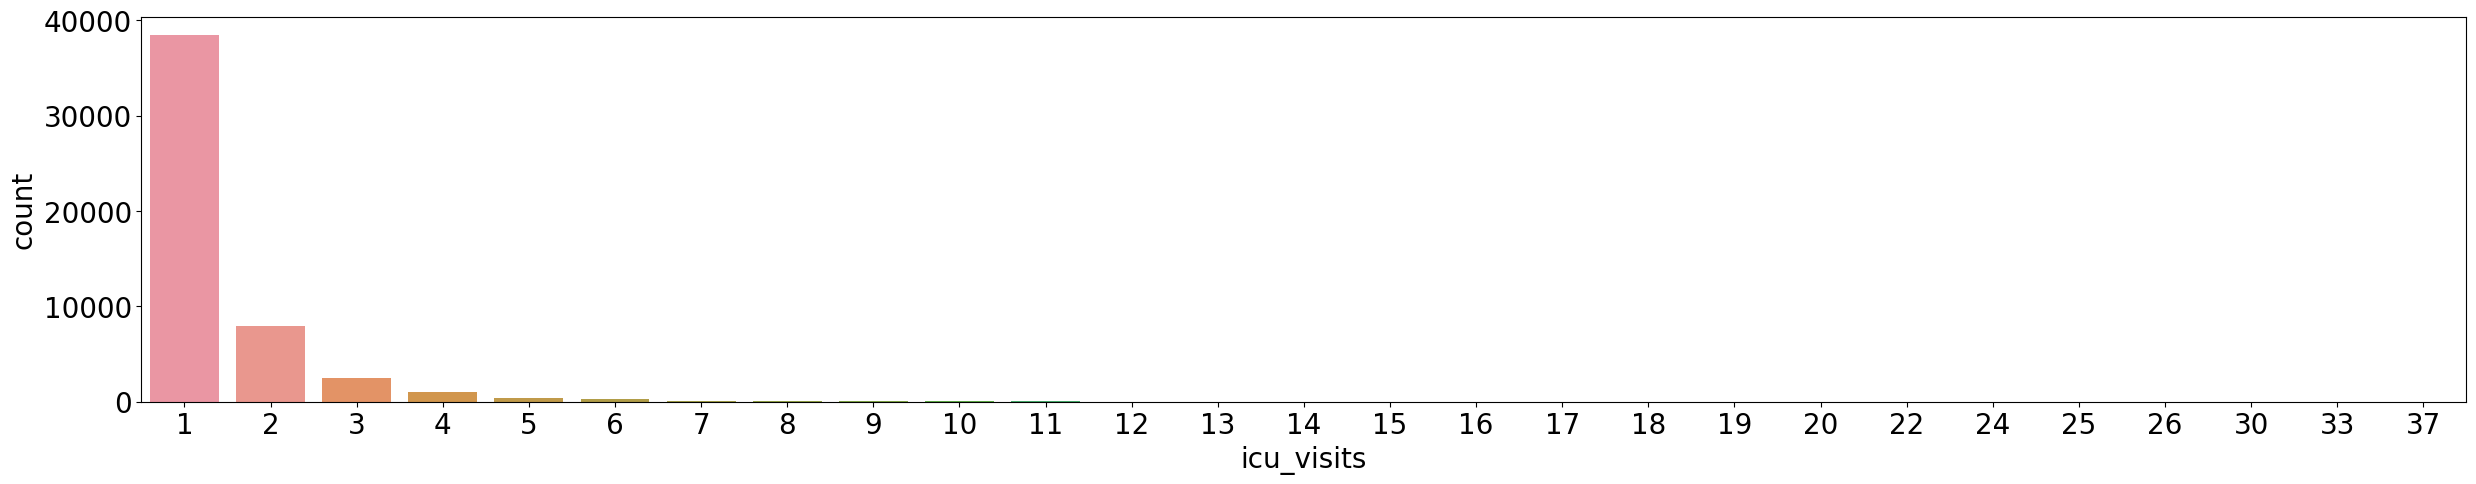

In [123]:
prob2.filter(pl.col('icu_visits') > 1).len(name)

data = prob2.collect().to_pandas()
plt.figure(figsize=(30, 5))
sns.countplot(
    data=data,
    x='icu_visits'
)
plt.show()

## Problem 3. `admissions` data

Information of the patients admitted into hospital is available in `admissions.csv.gz`. See https://mimic.mit.edu/docs/iv/modules/hosp/admissions/ for details of each field in this file. The first 10 lines are

In [12]:
!zcat < ~/mimic/hosp/admissions.csv.gz | head

/bin/bash: line 1: /home/wtmartinez/mimic/hosp/admissions.csv.gz: No such file or directory


### (A). Ingestion
Import `admissions.csv.gz` as a data frame `admissions_df`.

### (B). Summary and visualization

Summarize the following information by graphics and explain any patterns you see.

- number of admissions per patient
- admission hour of day (anything unusual?)
- admission minute (anything unusual?)
- length of hospital stay (from admission to discharge) (anything unusual?)

According to the MIMIC-IV documentation:

> All dates in the database have been shifted to protect patient confidentiality. Dates will be internally consistent for the same patient, but randomly distributed in the future. Dates of birth which occur in the present time are not true dates of birth. Furthermore, dates of birth which occur before the year 1900 occur if the patient is older than 89. In these cases, the patient’s age at their first admission has been fixed to 300.

## Problem 4. `patients` data
Patient information is available in `patients.csv.gz`. See https://mimic.mit.edu/docs/iv/modules/hosp/patients/ for details of each field in this file. The first 10 lines are:

In [13]:
!zcat < ~/mimic/hosp/patients.csv.gz | head

/bin/bash: line 1: /home/wtmartinez/mimic/hosp/patients.csv.gz: No such file or directory


### (A). Ingestion
Import `patients.csv.gz` (https://mimic.mit.edu/docs/iv/modules/hosp/patients/) as a data frame `patients_df`.

### (B). Summary and visaulization
Summarize variables `gender` and `anchor_age` by graphics, and explain any patterns you see.

## Problem 5. Lab results
labevents.csv.gz (https://mimic.mit.edu/docs/iv/modules/hosp/labevents/) contains all laboratory measurements for patients. The first 10 lines are

In [14]:
!zcat < ~/mimic/hosp/labevents.csv.gz | head

/bin/bash: line 1: /home/wtmartinez/mimic/hosp/labevents.csv.gz: No such file or directory


`d_labitems.csv.gz` (https://mimic.mit.edu/docs/iv/modules/hosp/d_labitems/) is the dictionary of lab measurements.

In [15]:
!zcat < ~/mimic/hosp/d_labitems.csv.gz | head

/bin/bash: line 1: /home/wtmartinez/mimic/hosp/d_labitems.csv.gz: No such file or directory


We are interested in the lab measurements of creatinine (50912), potassium (50971), sodium (50983), chloride (50902), bicarbonate (50882), hematocrit (51221), white blood cell count (51301), and glucose (50931). Retrieve a subset of `labevents.csv.gz` that only containing these items for the patients in `icustays_df`. Further restrict to the last available measurement (by `storetime`) before the ICU stay. The final `labevents_df` should have one row per ICU stay and columns for each lab measurement.
(ten columns with column names `subject_id`, `stay_id`, `Bicarbonate`, `Chloride`, ...)


_Hint_: Use the Parquet format you generated in Homework 3. For reproducibility, make `labevents.parquet` file available at the current working directory, for example, by a symbolic link.

## Problem 6. Vitals from charted events

`chartevents.csv.gz` (https://mimic.mit.edu/docs/iv/modules/icu/chartevents/) contains all the charted data available for a patient. During their ICU stay, the primary repository of a patient’s information is their electronic chart. The `itemid` variable indicates a single measurement type in the database. The `value` variable is the value measured for `itemid`. The first 10 lines of `chartevents.csv.gz` are

In [16]:
!zcat < ~/mimic/icu/chartevents.csv.gz | head

/bin/bash: line 1: /home/wtmartinez/mimic/icu/chartevents.csv.gz: No such file or directory


`d_items.csv.gz` (https://mimic.mit.edu/docs/iv/modules/icu/d_items/) is the dictionary for the itemid in `chartevents.csv.gz`.

In [17]:
!zcat < ~/mimic/icu/d_items.csv.gz | head

/bin/bash: line 1: /home/wtmartinez/mimic/icu/d_items.csv.gz: No such file or directory


We are interested in the vitals for ICU patients: heart rate (220045), systolic non-invasive blood pressure (220179), diastolic non-invasive blood pressure (220180), body temperature in Fahrenheit (223761), and respiratory rate (220210). Retrieve a subset of `chartevents.csv.gz` only containing these items for the patients in `icustays_tble`. Further restrict to the first vital measurement within the ICU stay. The final `chartevents_tble` should have one row per ICU stay and columns for each vital measurement.

Hint: Use the Parquet format you generated in Homework 3. For reproducibility, make `chartevents.parquet` file available at the current working directory, for example, by a symbolic link.

## Problem 7. Putting things together
Let us create a data frame `mimic_icu_cohort` for all ICU stays, where rows are all ICU stays of adults (age at `intime` >= 18) and columns contain at least following variables

- all variables in `icustays_tble`
- all variables in `admissions_tble`
- all variables in `patients_tble`
- the last lab measurements before the ICU stay in `labevents_tble`
- the first vital measurements during the ICU stay in `chartevents_tble`
- The final `mimic_icu_cohort` should have one row per ICU stay and columns for each variable.

## Problem 8. Exploratory data analysis (EDA)
Summarize the following information about the ICU stay cohort `mimic_icu_cohort` using appropriate method:

- Length of ICU stay `los` vs demographic variables (race, insurance, marital_status, gender, age at intime)

- Length of ICU stay `los` vs the last available lab measurements before ICU stay

- Length of ICU stay `los` vs the first vital measurements within the ICU stay

- Length of ICU stay `los` vs first ICU unit

At least two plots should be created, with at least one them including multiple facets using an appropriate keyword argument. 